# Astrometric observation simulations with MICADO and SCAO

In this eample we demonstate the sub-pixel precision of ScopeSim simulation by creating a grid of moving stars and simulating observations of two epochs.
The second part then applies the same workflow to the motions of stars in a star cluster.
For the sake of computational speed we use the ``MICADO`` package.
We use the wide-field mode (4 mas / pixel) so that the sub-pixel motions of the stars are visible in the flux distribution of the PSF cores.

In [1]:
%matplotlib inline
import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy import units as u
import yaml
from pprint import pprint
import copy
from astropy.io import fits

import scopesim as sim
import scopesim_templates as sim_tp

## Set up a source with 1 star

For the first part of this exercise we create a grid of stars seperated by 32 mas.
The ``ScopeSim_templates`` pacakge has a helper function for making griods of stars in the ``basic.stars`` submodule:

['A0V']


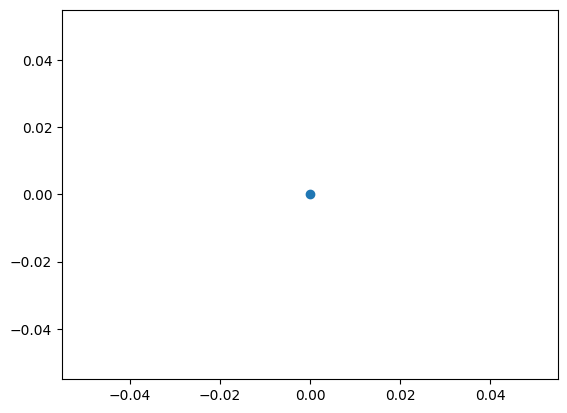

In [2]:
stars = sim_tp.star_grid(n=1, mmin=15, mmax=15, filter_name="Ks", separation=0.032)

plt.scatter(stars.fields[0]["x"], stars.fields[0]["y"])

In [3]:
yaml_detector_odd = {
    'alias': 'DET',
    'description': 'The detector and electronic properties and effects',
    'name': 'basic_detector',
    'object': 'detector',
    'properties': {
        'dit': '!OBS.dit',
        'image_plane_id': 0,
        'ndit': '!OBS.ndit',
        'temperature': -230,
        'width': 11,
        'height': 11,
        'x': 0,
        'y': 0,
    },
    'effects': [{
        'name': 'detector_window',
        'class': 'DetectorWindow',
        'description': 'Cut-out of the focal plane image with custom dimensions and coordinates',
        'kwargs': {
            'height': '!DET.height',
            'image_plane_id': 0,
            'pixel_size': 0.01,
            'units': 'pixel',
            'width': '!DET.width',
            'x': '!DET.x',
            'y': '!DET.y',
        },
    }],
}

yaml_detector_even = copy.deepcopy(yaml_detector_odd)
yaml_detector_even["properties"]["width"] = 12
yaml_detector_even["properties"]["height"] = 12



In [4]:
yaml_instrument = {
    "object": "instrument",
    "alias": "INST",
    "name": "basic_instrument",
    "description": "Effects from the common optics",
    
    "properties": {
        "temperature": -190.,
        "pixel_scale": 0.2,       # arcsec / pixel
        "plate_scale": 20.,        # arcsec / mm
        # "pixel_size": 0.01,    # mm / pixel
    },
    
    "effects": [{
        "name": "static_surfaces",
        "description": "surfaces list for common optics",
        "class": "SurfaceList",
        "kwargs": {
            # "filename": "INS_common_optics.dat",
            "array_dict": {
                "name": ["entr_window"],
                "outer": [0.5],
                "inner": [0.0],
                "angle": [0.0],
                "temperature": [7.0],
                "action": ["transmission"],
                "filename": ["INS_unity_trans.dat"],
            },
        },
    }],
}

In [5]:
yaml_telescope = {
    "object": "telescope",
    "alias": "TEL",
    "name": "basic_telescope",
    "description": "The telescope",
    
    "properties": {
        "temperature": 0.,
    },
    
    "effects": [{
        "name": "psf",
        "description": "Seeing limited PSF",
        "class": "SeeingPSF",
        "kwargs": {
            "fwhm": "!OBS.psf_fwhm", # [arcsec]
        },
    }],
}

In [6]:
yaml_telescope_fieldconstantpsf = {
    "object": "telescope",
    "alias": "TEL",
    "name": "basic_telescope",
    "description": "The telescope",
    
    "properties": {
        "temperature": 0.,
    },
    
    "effects": [{
        "name": "psf",
        "description": "Copy of Seeing limited PSF",
        "class": "FieldConstantPSF",
        "kwargs": {
            "filename": "seeingpsfinput.fits", # Created below
        },
    }],
}

## Set up the MICADO system for SCAO 4mas Pa-beta observations

The next step is to set up the ``MICADO`` optical system using the ``SCAO`` and wide-field optics (``IMG_4mas``) modes.
As we know in advance that we want to use the Pa-Beta filter, we can set this parameter by passing a dictionary to the ``properties=`` keyword.

Additionally, we are only interested in a small section of the detector around where the 4 stars will be located.
We can therefore set our Detector to only read out the desired window area.
The required "!-bang" string keywords for this are ``!DET.width`` and ``!DET.height`` (given in units of pixels).

As we are interested in the sub-pixel movements of the stars, it is also important to set the ``!SIM.sub_pixel.flag`` to True

Given that we are observing at a non-standard broadband filter, we need to instruct the ``OpticalTrain`` to adjust the PSF strehl ratio.
This is done with the ``!INST.psf`` dictionary.

In [7]:
observation_dict_without_sub_pixel = {
    "!OBS.filter_name_pupil": "Pa-beta",
    "!OBS.filter_name_fw1": "open",
    "!OBS.filter_name_fw2": "open", 
    "!INST.filter_name": "Pa-beta",
    "!OBS.ndit": 20, 
    "!OBS.dit": 3,
    "!OBS.exptime": 60,

    "!OBS.instrument": "MICADO",
    "!OBS.catg": "SCIENCE",
    "!OBS.tech": "IMAGE",
    "!OBS.type": "OBJECT",
    "!OBS.mjdobs": datetime.datetime(2022, 1, 1, 2, 30, 0),


    "!OBS.psf_fwhm": 1.5,             # [arcsec]
    "!OBS.slit_name": "narrow",

    "!OBS.include_slit": False,
    "!OBS.include_slicer": False,
    "!OBS.filter_name": "J",

    "!TEL.temperature": 7.0,

    "!INST.temperature": -190,
    "!INST.pixel_scale": 0.2,       # arcsec / pixel
    "!INST.plate_scale": 20,        # arcsec / mm

    "!OBS.modes": ["imaging"],
    "!TEL.telescope": "EvLT",
    "!ATMO.location": "Here",

    # sub_pixel.flag also moves by half a pixel
    "!SIM.sub_pixel.flag": False,
    # "!SIM.sub_pixel.flag": True,
}

observation_dict_with_sub_pixel = copy.copy(observation_dict_without_sub_pixel)
observation_dict_with_sub_pixel["!SIM.sub_pixel.flag"] = True

# Odd number of pixels, no sub pixels

In [8]:
yaml_detector = yaml_detector_odd

In [9]:
observation_dict = observation_dict_without_sub_pixel

## Point source, no PSF

In [10]:
cmd = sim.UserCommands(
    yamls = [
        # yaml_telescope,

        yaml_instrument,

        yaml_detector,
    ],
    
    properties=copy.deepcopy(observation_dict),
)
micado = sim.OpticalTrain(cmd)
micado.observe(stars)
hdus_pointsource = micado.readout()


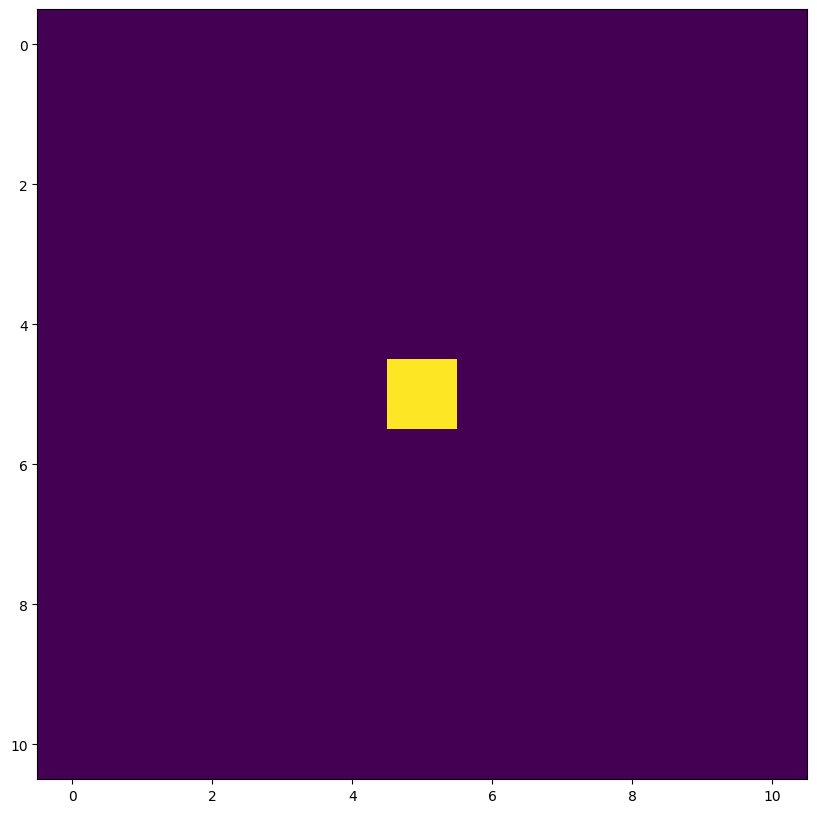

In [11]:
plt.figure(figsize=(10,10))
plt.imshow(hdus_pointsource[0][1].data)

## SeeingPSF

In [12]:
cmd = sim.UserCommands(
    yamls = [
        yaml_telescope,

        yaml_instrument,

        yaml_detector,
    ],
    
    properties=copy.deepcopy(observation_dict),
)
micado = sim.OpticalTrain(cmd)
micado.observe(stars)
hdus_seeingpsf = micado.readout(filename="seeingpsf.fits")


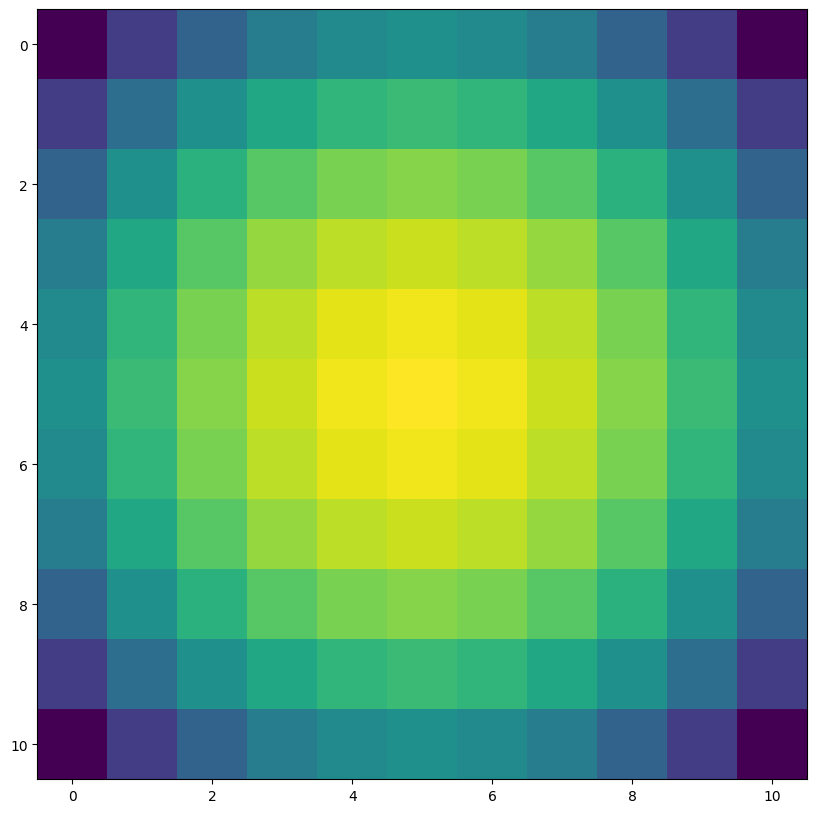

In [13]:
plt.figure(figsize=(10,10))
plt.imshow(hdus_seeingpsf[0][1].data, norm=LogNorm())

In [14]:
hdus = fits.open("seeingpsf.fits")
hdus[1].header["WAVE0"] = 1.6
hdus[1].header
hdus.writeto("seeingpsfinput.fits", overwrite=True)


## FieldConstantPSF

In [15]:
cmd = sim.UserCommands(
    yamls = [
        yaml_telescope_fieldconstantpsf,

        yaml_instrument,

        yaml_detector,
    ],
    
    properties=copy.deepcopy(observation_dict),
)
cmd["!SIM.sub_pixel.flag"]= False
micado = sim.OpticalTrain(cmd)
micado.observe(stars)
hdus_fieldconstantpsf = micado.readout(filename="fieldconstantpsf.fits")


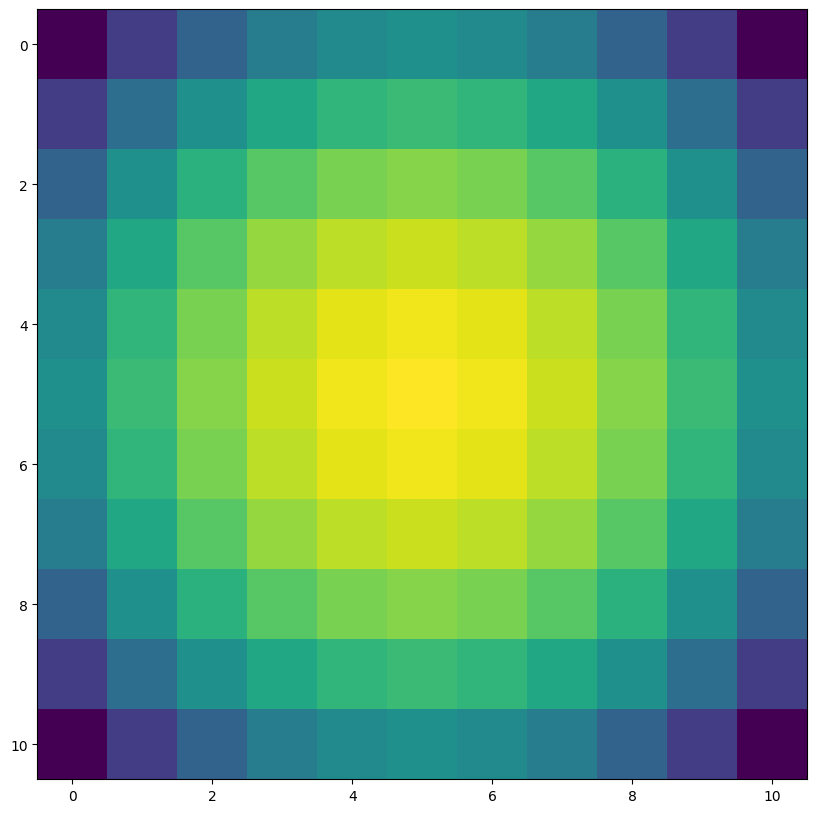

In [16]:
plt.figure(figsize=(10,10))
plt.imshow(hdus_fieldconstantpsf[0][1].data, norm=LogNorm())

In [17]:
set(hdus_fieldconstantpsf[0][1].data.flatten() / hdus_seeingpsf[0][1].data.flatten())

{1.1906045086230996,
 1.1906045086230999,
 1.1906045086231,
 1.1906045086231003,
 1.1906045086231005,
 1.1906045086231007,
 1.190604508623101,
 1.1906045086231012}

In [18]:
# So shape is identical, but there is a 19% offset.


## Simulate Source without PSF

In [19]:
hdus = fits.open("seeingpsf.fits")

In [20]:
src = sim.Source(image_hdu=hdus[1], flux=u.Unit("Jy"))

In [21]:
cmd = sim.UserCommands(
    yamls = [
        # yaml_telescope,

        yaml_instrument,

        yaml_detector,
    ],
    
    properties=copy.deepcopy(observation_dict),
)
micado = sim.OpticalTrain(cmd)
micado.observe(src)
hdus_extended = micado.readout()


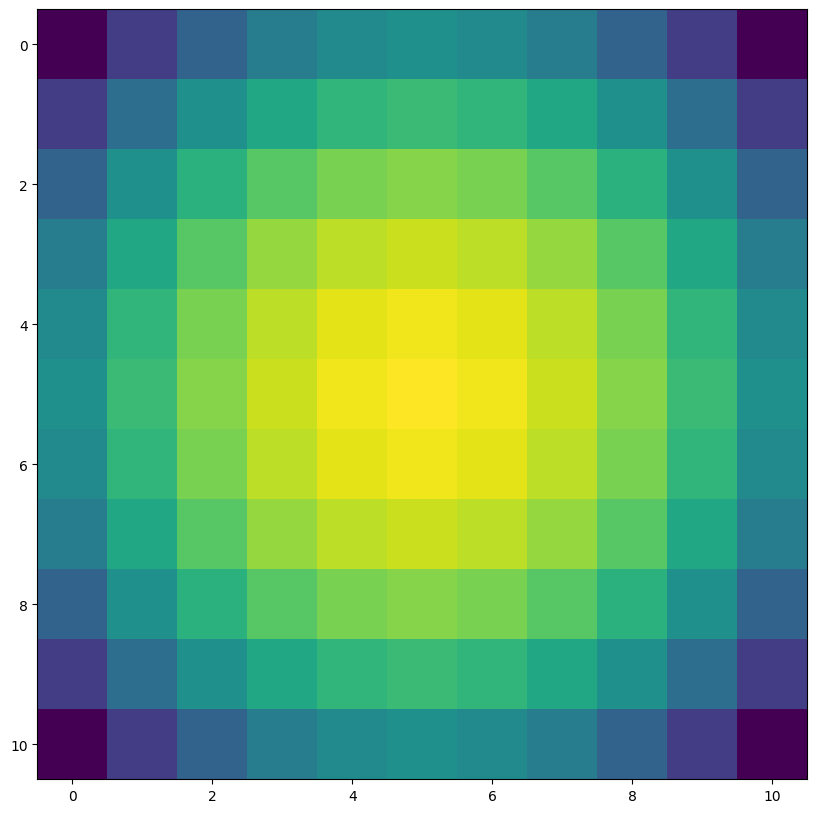

In [22]:
plt.figure(figsize=(10,10))
plt.imshow(hdus_extended[0][1].data, norm=LogNorm())

In [23]:
set(hdus_extended[0][1].data[1:,1:].flatten() / hdus_seeingpsf[0][1].data[:-1,:-1].flatten())

{5143397.052082606,
 5673984.15612069,
 5673984.156120693,
 6259306.03410697,
 6259306.034106971,
 6259306.034106972,
 6905009.064282368,
 6905009.064282371,
 6905009.064282372,
 6905009.064282375,
 7617322.098970382,
 7617322.098970383,
 7617322.098970384,
 8403116.551953847,
 8403116.551953848,
 8403116.551953852,
 8403116.551953854,
 9269972.684398528,
 9269972.684398532,
 9269972.684398534,
 9269972.684398538,
 10226252.72875864,
 10226252.728758642,
 10226252.728758644,
 11281181.55606289,
 11281181.556062892,
 11281181.556062894,
 11281181.556062896,
 11281181.556062898,
 12444935.664747864,
 12444935.664747866,
 12444935.664747868,
 12444935.66474787,
 12444935.664747875,
 13728741.349480143,
 13728741.349480145,
 13728741.349480147,
 13728741.349480148,
 13728741.34948015,
 13728741.349480152,
 15144982.99696469,
 15144982.996964693,
 15144982.996964695,
 15144982.996964699,
 16707322.553428033,
 16707322.553428035,
 16707322.55342804,
 18430831.316233777,
 18430831.316233784,


In [24]:
# So shape is wrong, but ratio is constant

In [25]:
set(hdus_extended[0][1].data.flatten() / hdus_seeingpsf[0][1].data.flatten())

{12444935.664747866, 12444935.664747868, 12444935.66474787}

# Odd number of pixels, with sub pixels

In [26]:
observation_dict = observation_dict_with_sub_pixel

## Point source, no PSF

In [27]:
cmd = sim.UserCommands(
    yamls = [
        # yaml_telescope,

        yaml_instrument,

        yaml_detector,
    ],
    
    properties=copy.deepcopy(observation_dict),
)
micado = sim.OpticalTrain(cmd)
micado.observe(stars)
hdus_pointsource = micado.readout()


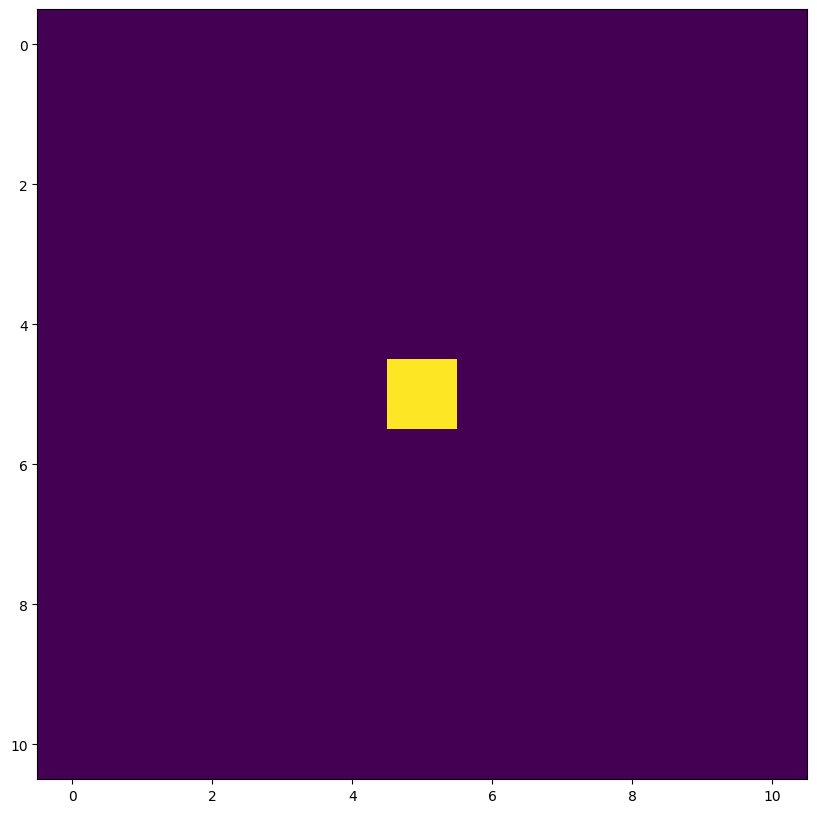

In [28]:
plt.figure(figsize=(10,10))
plt.imshow(hdus_pointsource[0][1].data)

## SeeingPSF

In [29]:
cmd = sim.UserCommands(
    yamls = [
        yaml_telescope,

        yaml_instrument,

        yaml_detector,
    ],
    
    properties=copy.deepcopy(observation_dict),
)
micado = sim.OpticalTrain(cmd)
micado.observe(stars)
hdus_seeingpsf = micado.readout(filename="seeingpsf.fits")


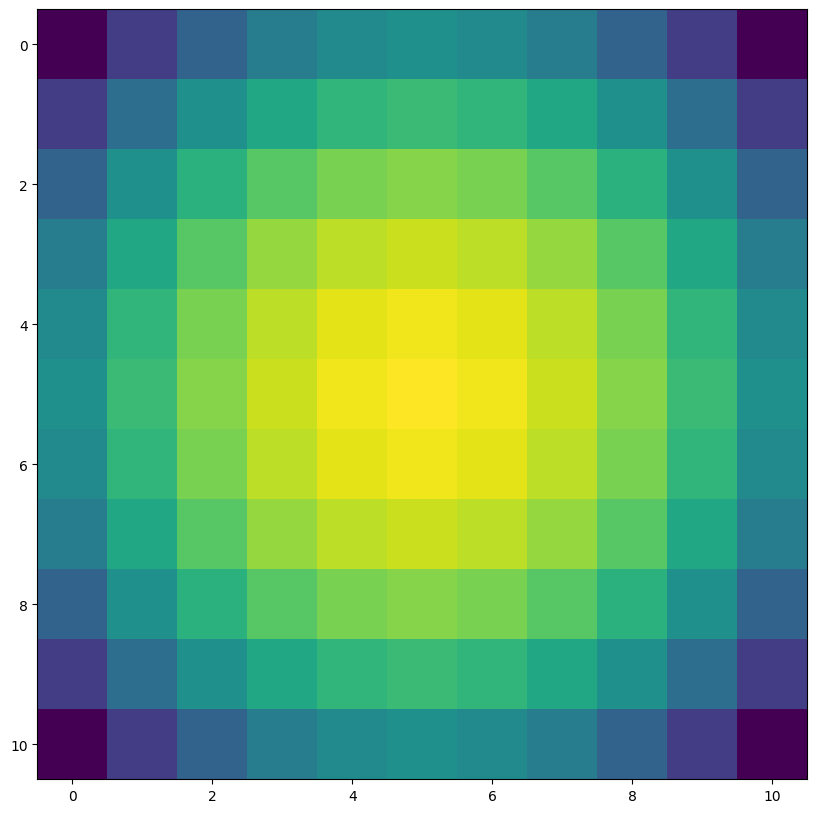

In [30]:
plt.figure(figsize=(10,10))
plt.imshow(hdus_seeingpsf[0][1].data, norm=LogNorm())

In [31]:
hdus = fits.open("seeingpsf.fits")
hdus[1].header["WAVE0"] = 1.6
hdus[1].header
hdus.writeto("seeingpsfinput.fits", overwrite=True)


## FieldConstantPSF

In [32]:
cmd = sim.UserCommands(
    yamls = [
        yaml_telescope_fieldconstantpsf,

        yaml_instrument,

        yaml_detector,
    ],
    
    properties=copy.deepcopy(observation_dict),
)
cmd["!SIM.sub_pixel.flag"]= False
micado = sim.OpticalTrain(cmd)
micado.observe(stars)
hdus_fieldconstantpsf = micado.readout(filename="fieldconstantpsf.fits")


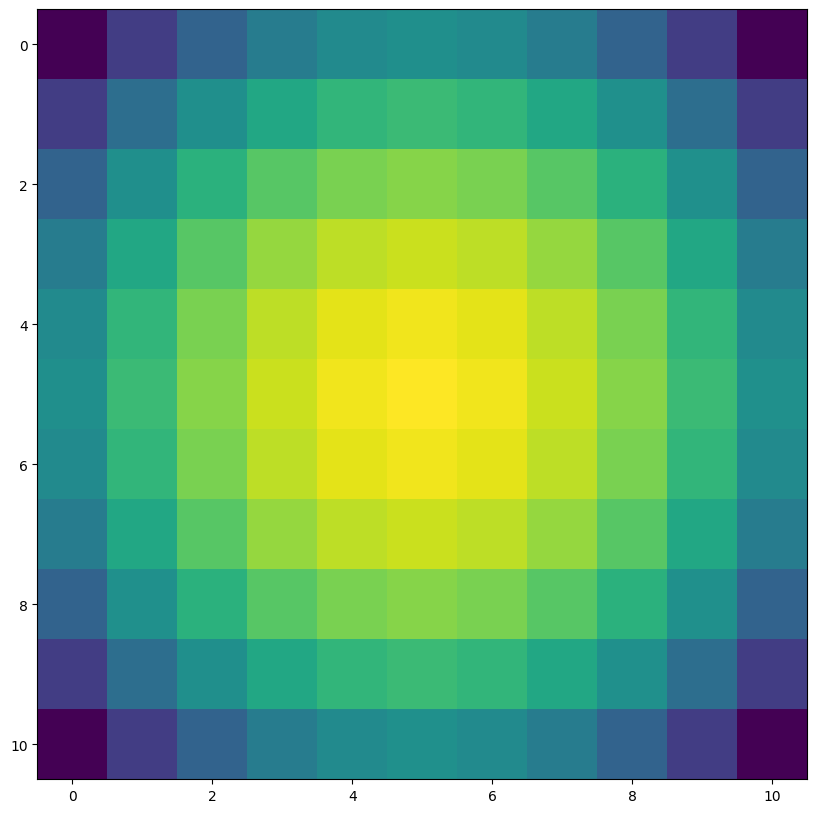

In [33]:
plt.figure(figsize=(10,10))
plt.imshow(hdus_fieldconstantpsf[0][1].data, norm=LogNorm())

In [34]:
set(hdus_fieldconstantpsf[0][1].data.flatten() / hdus_seeingpsf[0][1].data.flatten())

{1.1906045086230999,
 1.1906045086231,
 1.1906045086231003,
 1.1906045086231005,
 1.1906045086231007,
 1.190604508623101,
 1.1906045086231012,
 1.1906045086231014}

In [35]:
# So shape is identical, but there is a 19% offset.


## Simulate Source without PSF

In [36]:
hdus = fits.open("seeingpsf.fits")

In [37]:
src = sim.Source(image_hdu=hdus[1], flux=u.Unit("Jy"))

In [38]:
cmd = sim.UserCommands(
    yamls = [
        # yaml_telescope,

        yaml_instrument,

        yaml_detector,
    ],
    
    properties=copy.deepcopy(observation_dict),
)
micado = sim.OpticalTrain(cmd)
micado.observe(src)
hdus_extended = micado.readout()


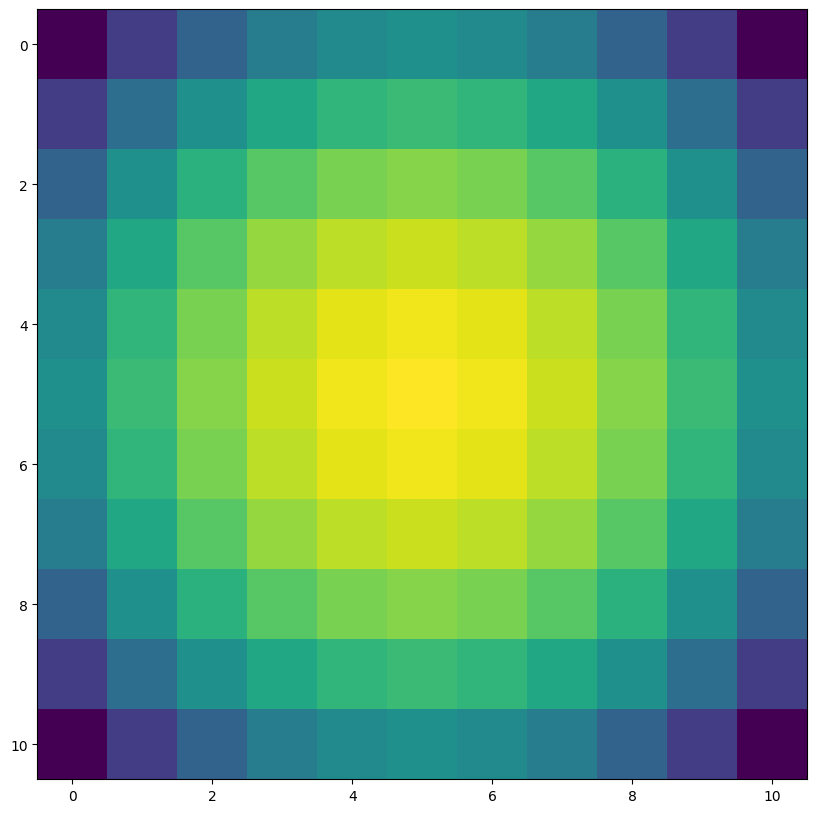

In [39]:
plt.figure(figsize=(10,10))
plt.imshow(hdus_extended[0][1].data, norm=LogNorm())

In [40]:
set(hdus_extended[0][1].data[1:,1:].flatten() / hdus_seeingpsf[0][1].data[:-1,:-1].flatten())

{5143397.052082606,
 5673984.156120692,
 6259306.034106972,
 6259306.034106974,
 6905009.064282372,
 6905009.064282373,
 6905009.064282375,
 7617322.098970384,
 7617322.098970386,
 7617322.098970387,
 8403116.551953848,
 8403116.55195385,
 8403116.551953852,
 8403116.551953856,
 9269972.684398534,
 9269972.684398536,
 9269972.68439854,
 10226252.72875864,
 10226252.728758644,
 10226252.728758646,
 10226252.728758648,
 11281181.55606289,
 11281181.556062894,
 11281181.556062896,
 11281181.556062898,
 11281181.5560629,
 11281181.556062901,
 12444935.664747864,
 12444935.664747868,
 12444935.66474787,
 12444935.664747871,
 12444935.664747873,
 12444935.664747877,
 13728741.349480145,
 13728741.349480147,
 13728741.349480148,
 13728741.34948015,
 13728741.349480152,
 13728741.349480156,
 15144982.996964691,
 15144982.996964693,
 15144982.996964695,
 15144982.996964702,
 16707322.553428033,
 16707322.553428037,
 16707322.55342804,
 16707322.553428045,
 18430831.31623378,
 18430831.316233784

In [41]:
# So shape is wrong, but ratio is constant

In [42]:
set(hdus_extended[0][1].data.flatten() / hdus_seeingpsf[0][1].data.flatten())

{12444935.664747866, 12444935.664747868, 12444935.66474787}

# Even number of pixels, no sub pixels

In [43]:
yaml_detector = yaml_detector_even

In [44]:
observation_dict = observation_dict_without_sub_pixel

## Point source, no PSF

In [45]:
cmd = sim.UserCommands(
    yamls = [
        # yaml_telescope,

        yaml_instrument,

        yaml_detector,
    ],
    
    properties=copy.deepcopy(observation_dict),
)
micado = sim.OpticalTrain(cmd)
micado.observe(stars)
hdus_pointsource = micado.readout()


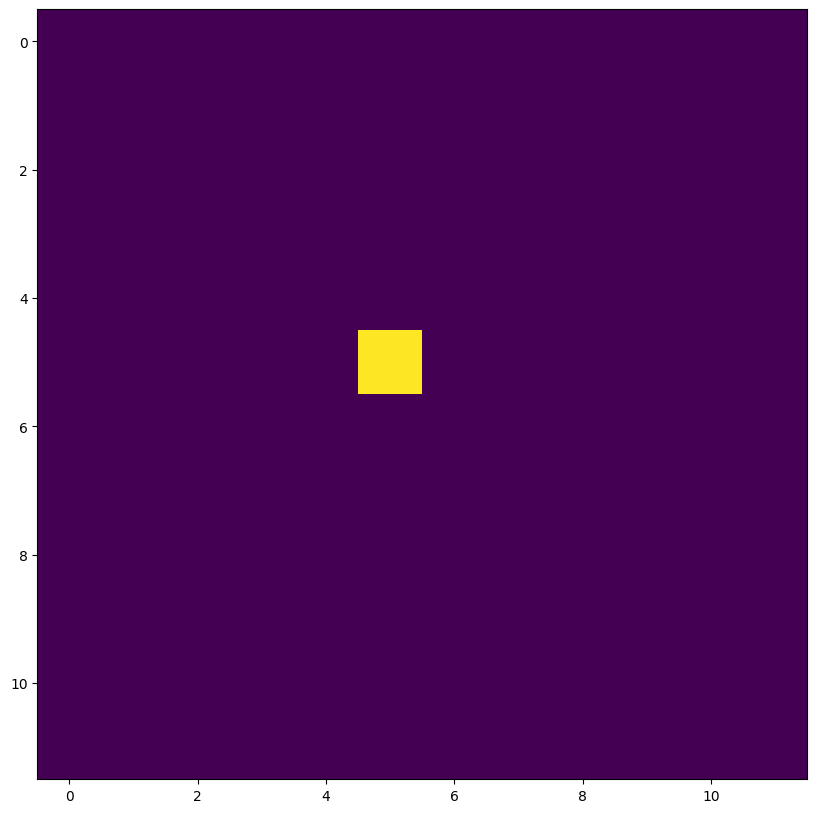

In [46]:
plt.figure(figsize=(10,10))
plt.imshow(hdus_pointsource[0][1].data)

## SeeingPSF

In [47]:
cmd = sim.UserCommands(
    yamls = [
        yaml_telescope,

        yaml_instrument,

        yaml_detector,
    ],
    
    properties=copy.deepcopy(observation_dict),
)
micado = sim.OpticalTrain(cmd)
micado.observe(stars)
hdus_seeingpsf = micado.readout(filename="seeingpsf.fits")


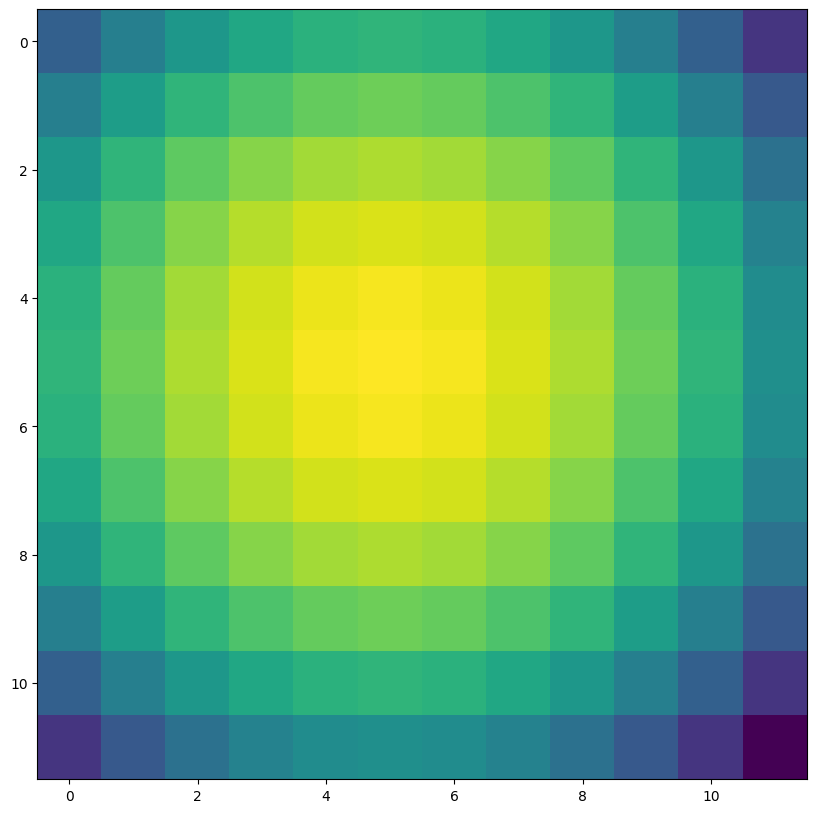

In [48]:
plt.figure(figsize=(10,10))
plt.imshow(hdus_seeingpsf[0][1].data, norm=LogNorm())

In [49]:
hdus = fits.open("seeingpsf.fits")
hdus[1].header["WAVE0"] = 1.6
hdus[1].header
hdus.writeto("seeingpsfinput.fits", overwrite=True)


## FieldConstantPSF

In [50]:
cmd = sim.UserCommands(
    yamls = [
        yaml_telescope_fieldconstantpsf,

        yaml_instrument,

        yaml_detector,
    ],
    
    properties=copy.deepcopy(observation_dict),
)
cmd["!SIM.sub_pixel.flag"]= False
micado = sim.OpticalTrain(cmd)
micado.observe(stars)
hdus_fieldconstantpsf = micado.readout(filename="fieldconstantpsf.fits")


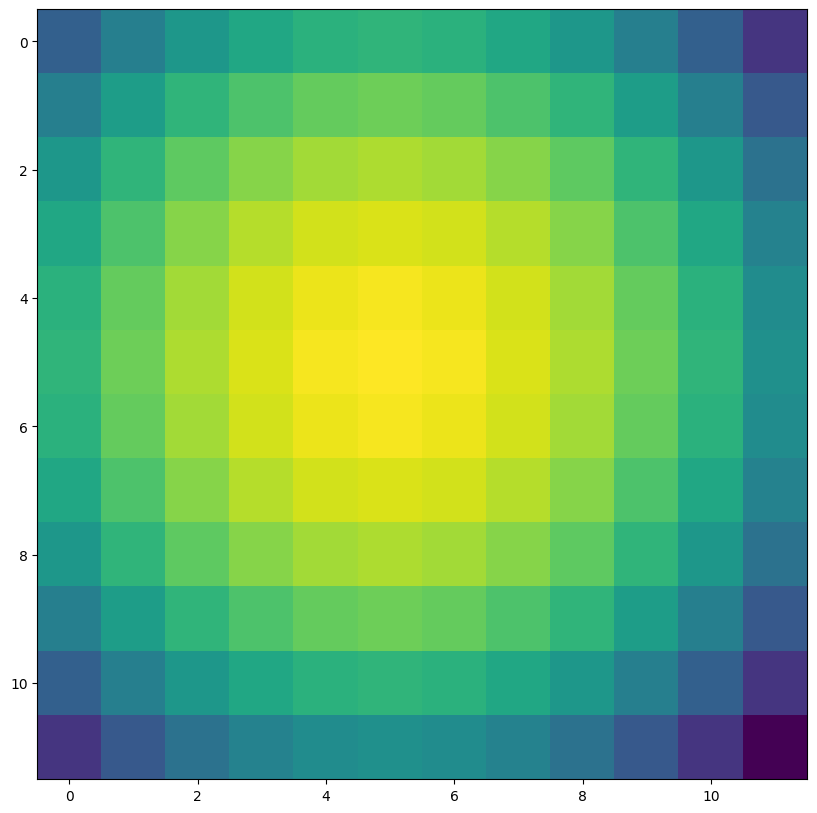

In [51]:
plt.figure(figsize=(10,10))
plt.imshow(hdus_fieldconstantpsf[0][1].data, norm=LogNorm())

In [52]:
set(hdus_fieldconstantpsf[0][1].data.flatten() / hdus_seeingpsf[0][1].data.flatten())

{1.1370066375548495,
 1.1370066375548507,
 1.1370066375548515,
 1.137006637554852,
 1.1370066375548524,
 1.1370066375548527,
 1.1370066375548529,
 1.137006637554853,
 1.1370066375548533,
 1.1370066375548535,
 1.1370066375548538,
 1.137006637554854,
 1.1370066375548542,
 1.1370066375548544,
 1.1370066375548546,
 1.137006637554855}

In [53]:
# So shape is identical, but there is a 19% offset.


## Simulate Source without PSF

In [54]:
hdus = fits.open("seeingpsf.fits")

In [55]:
src = sim.Source(image_hdu=hdus[1], flux=u.Unit("Jy"))

In [56]:
cmd = sim.UserCommands(
    yamls = [
        # yaml_telescope,

        yaml_instrument,

        yaml_detector,
    ],
    
    properties=copy.deepcopy(observation_dict),
)
micado = sim.OpticalTrain(cmd)
micado.observe(src)
hdus_extended = micado.readout()


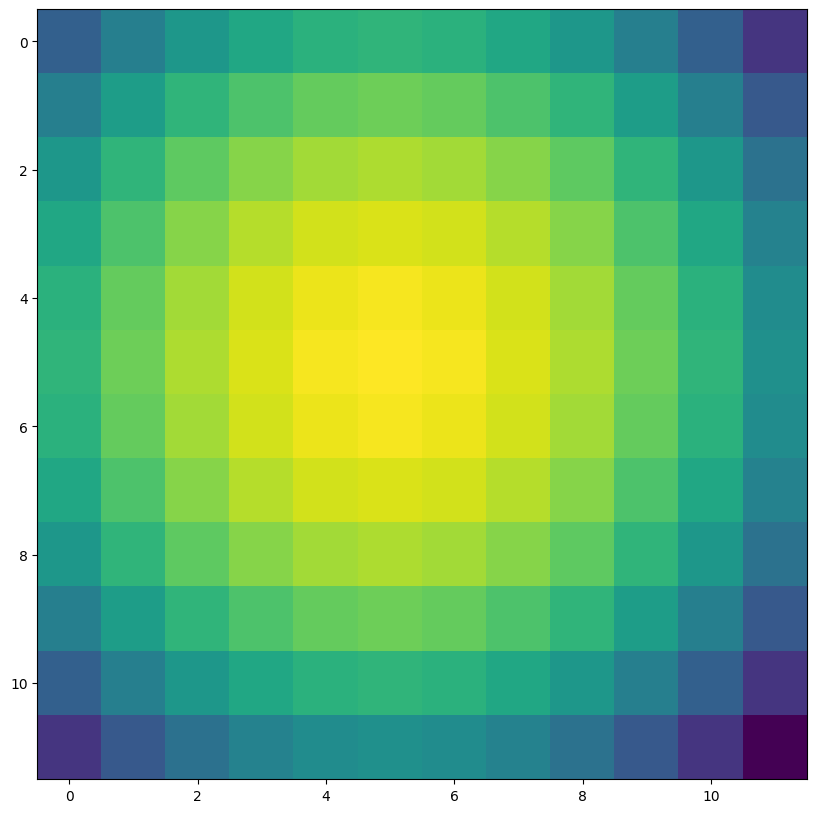

In [57]:
plt.figure(figsize=(10,10))
plt.imshow(hdus_extended[0][1].data, norm=LogNorm())

In [58]:
set(hdus_extended[0][1].data[1:,1:].flatten() / hdus_seeingpsf[0][1].data[:-1,:-1].flatten())

{4226432.305949136,
 4662426.349364187,
 4662426.349364191,
 5143397.052082604,
 5143397.052082606,
 5143397.052082607,
 5673984.15612069,
 5673984.156120693,
 5673984.156120695,
 5673984.156120701,
 6259306.03410697,
 6259306.034106971,
 6259306.034106972,
 6259306.034106973,
 6259306.034106976,
 6905009.064282368,
 6905009.064282371,
 6905009.064282372,
 6905009.064282373,
 6905009.064282375,
 7617322.09897038,
 7617322.098970382,
 7617322.098970383,
 7617322.098970384,
 8403116.551953847,
 8403116.551953848,
 8403116.551953852,
 8403116.551953854,
 9269972.684398528,
 9269972.684398532,
 9269972.684398534,
 9269972.684398538,
 9269972.68439854,
 9269972.684398541,
 10226252.72875864,
 10226252.728758642,
 10226252.728758644,
 10226252.728758646,
 11281181.55606289,
 11281181.556062892,
 11281181.556062894,
 11281181.556062896,
 11281181.556062898,
 11281181.556062903,
 11281181.556062914,
 12444935.664747864,
 12444935.664747866,
 12444935.664747868,
 12444935.66474787,
 12444935.66

In [59]:
# So shape is wrong, but ratio is constant

In [60]:
set(hdus_extended[0][1].data.flatten() / hdus_seeingpsf[0][1].data.flatten())

{12444935.664747866, 12444935.664747868, 12444935.66474787}

# Even number of pixels, with sub pixels

In [61]:
yaml_detector = yaml_detector_even

In [62]:
observation_dict = observation_dict_with_sub_pixel

## Point source, no PSF

In [63]:
cmd = sim.UserCommands(
    yamls = [
        # yaml_telescope,

        yaml_instrument,

        yaml_detector,
    ],
    
    properties=copy.deepcopy(observation_dict),
)
micado = sim.OpticalTrain(cmd)
micado.observe(stars)
hdus_pointsource = micado.readout()


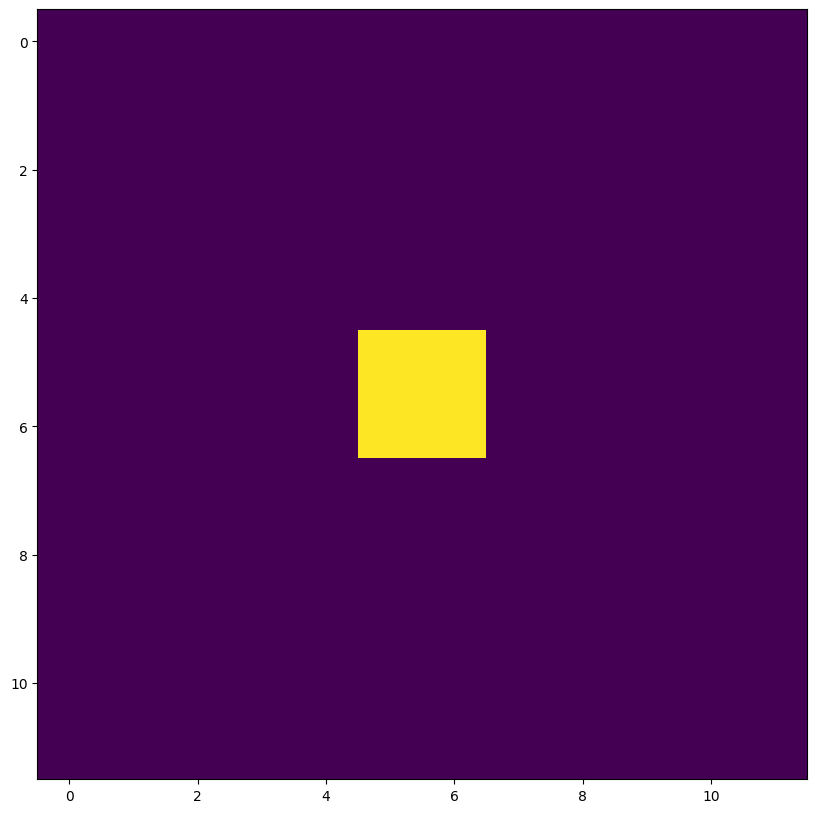

In [64]:
plt.figure(figsize=(10,10))
plt.imshow(hdus_pointsource[0][1].data)

## SeeingPSF

In [65]:
cmd = sim.UserCommands(
    yamls = [
        yaml_telescope,

        yaml_instrument,

        yaml_detector,
    ],
    
    properties=copy.deepcopy(observation_dict),
)
micado = sim.OpticalTrain(cmd)
micado.observe(stars)
hdus_seeingpsf = micado.readout(filename="seeingpsf.fits")


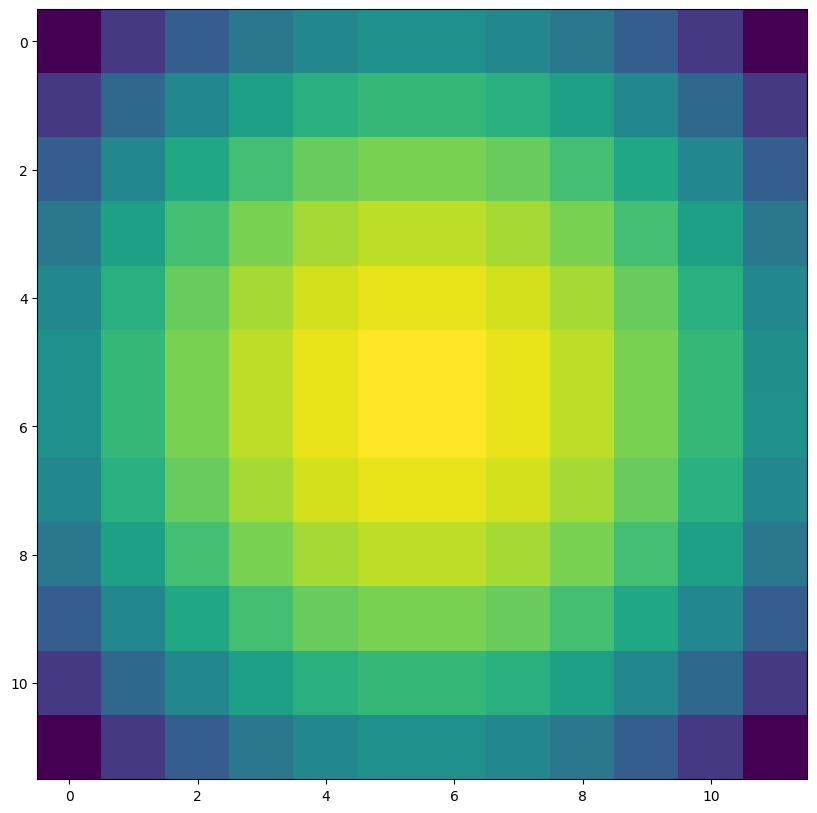

In [66]:
plt.figure(figsize=(10,10))
plt.imshow(hdus_seeingpsf[0][1].data, norm=LogNorm())

In [67]:
hdus = fits.open("seeingpsf.fits")
hdus[1].header["WAVE0"] = 1.6
hdus[1].header
hdus.writeto("seeingpsfinput.fits", overwrite=True)


## FieldConstantPSF

In [68]:
cmd = sim.UserCommands(
    yamls = [
        yaml_telescope_fieldconstantpsf,

        yaml_instrument,

        yaml_detector,
    ],
    
    properties=copy.deepcopy(observation_dict),
)
cmd["!SIM.sub_pixel.flag"]= False
micado = sim.OpticalTrain(cmd)
micado.observe(stars)
hdus_fieldconstantpsf = micado.readout(filename="fieldconstantpsf.fits")


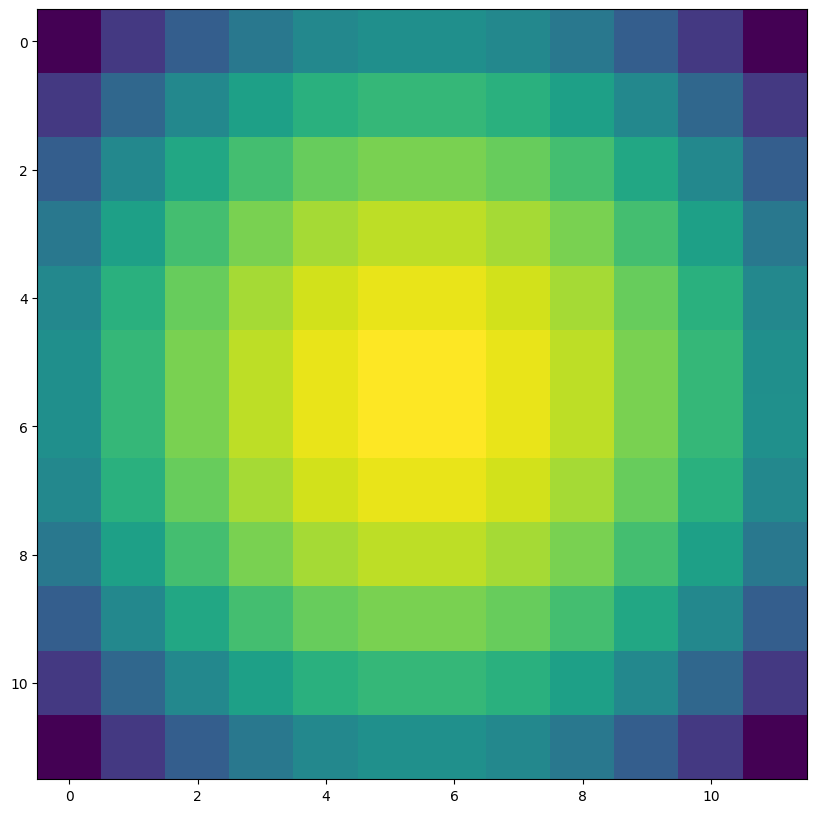

In [69]:
plt.figure(figsize=(10,10))
plt.imshow(hdus_fieldconstantpsf[0][1].data, norm=LogNorm())

In [70]:
set(hdus_fieldconstantpsf[0][1].data.flatten() / hdus_seeingpsf[0][1].data.flatten())

{1.1370066375548529,
 1.137006637554853,
 1.1370066375548533,
 1.1370066375548535,
 1.1370066375548538,
 1.137006637554854,
 1.1370066375548542,
 1.1370066375548544,
 1.1370066375548546,
 1.1370066375548549}

In [71]:
# So shape is identical, but there is a 19% offset.


## Simulate Source without PSF

In [72]:
hdus = fits.open("seeingpsf.fits")

In [73]:
src = sim.Source(image_hdu=hdus[1], flux=u.Unit("Jy"))

In [74]:
cmd = sim.UserCommands(
    yamls = [
        # yaml_telescope,

        yaml_instrument,

        yaml_detector,
    ],
    
    properties=copy.deepcopy(observation_dict),
)
micado = sim.OpticalTrain(cmd)
micado.observe(src)
hdus_extended = micado.readout()


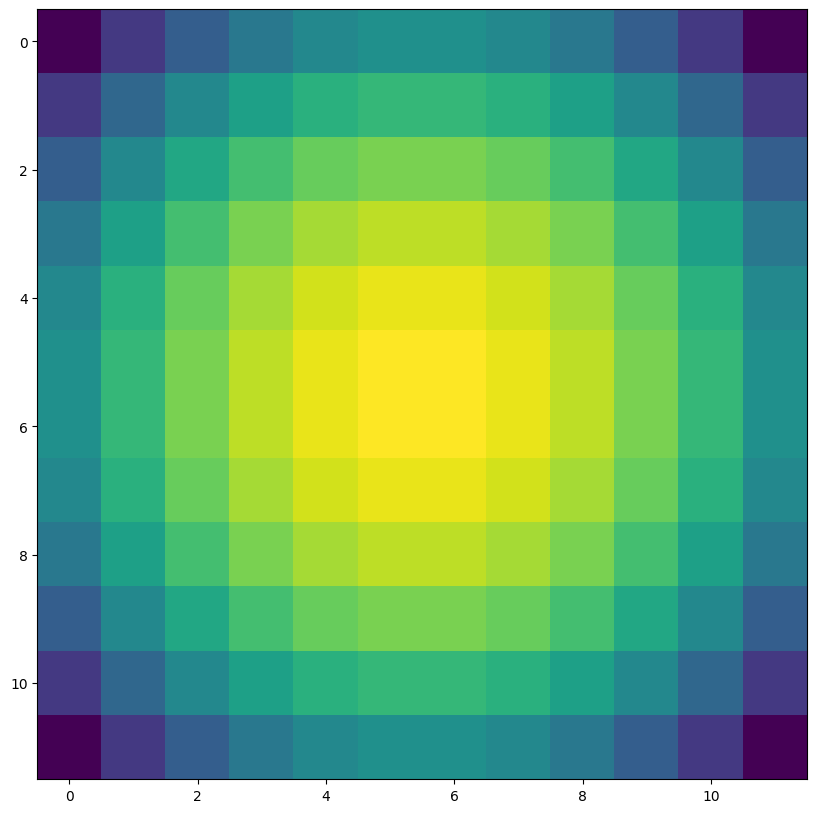

In [75]:
plt.figure(figsize=(10,10))
plt.imshow(hdus_extended[0][1].data, norm=LogNorm())

In [76]:
set(hdus_extended[0][1].data[1:,1:].flatten() / hdus_seeingpsf[0][1].data[:-1,:-1].flatten())

{4773864.753401769,
 5254258.6117359465,
 5254258.611735947,
 5782739.800080586,
 5782739.800080587,
 5782994.488758599,
 6364161.479285753,
 6364161.479285757,
 6364656.722281574,
 6364656.722281576,
 7003881.58317179,
 7003881.5831717905,
 7004586.846576954,
 7004586.846576958,
 7004823.413065336,
 7707816.793897769,
 7708681.964175045,
 7708681.9641750455,
 7709118.666208727,
 7709118.666208732,
 8482502.027309792,
 8482502.0273098,
 8483454.152772456,
 8483454.152772458,
 8484032.723633034,
 8484226.81131955,
 9335155.923001496,
 9335155.923001505,
 9336095.936589088,
 9336732.657547697,
 9336732.6575477,
 9337054.08083426,
 9337054.080834264,
 10273752.88915204,
 10273752.889152043,
 10274552.366691332,
 10274552.366691334,
 10275134.427014302,
 10275488.155411435,
 10275488.155411439,
 10275606.822781837,
 11307102.31803073,
 11307102.318030737,
 11307600.315699842,
 11307600.315699846,
 11307982.208216457,
 11307982.20821646,
 11308240.89888603,
 11308240.898886032,
 11308371.49

In [77]:
# So shape is wrong, but ratio is constant

In [78]:
set(hdus_extended[0][1].data.flatten() / hdus_seeingpsf[0][1].data.flatten())

{12444935.664747866, 12444935.664747868, 12444935.66474787}